# Preliminary analysis for NHS_OA project

This project aims to identify and analyse the research publications produced by
NHS staff. Aspects to be explored include: data collection and processing, open access status and type, and topic analysis. This is a preliminary analysis to explore the data collected in the early stages of the project and identify next steps.

In [45]:
import pandas as pd
import numpy as np
from ast import literal_eval
import seaborn as sns
import nltk
from nltk.corpus import stopwords 
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize 
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/yiwen-h/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yiwen-h/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yiwen-h/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Data sourcing

~~~
(nhs[Affiliation]) AND (("2019/10/01"[Date - Publication] : "2019/12/31"[Date - Publication]))
~~~

Preliminary data was obtained from Pubmed using the search string shown above. This produced approximately 25,000 papers. A number of different data sourcing options were explored, including using the Pubmed Entrez API, utilising the full dataset download via FTP, or different data download options directly from the Pubmed website. The 'Abstract - text' option from the Pubmed website offered the most reliability and functionality, although it was quite a manual process.

Future improvements for downloading further data from Pubmed:
- Try the Entrez API again
- Utilise Selenium to automate the downloading of data

Ultimately I would like to have at least 10 years of NHS publication data to analyse.

## Data augmentation and processing

[Pubmed processing package](https://github.com/yiwen-h/nhs_oa/blob/master/nhs_oa/data_from_pubmed.py)
The data obtained from Pubmed was in raw txt format. Regex was used to extract key information from the txt, namely:
- doi
- pmid
- affiliations
- abstract

Using the DOI, the data was then supplemented with further metadata obtained from the sources below. I utilised APIs to obtain this information and saved it as a CSV file for further use.

[Crossref](https://github.com/yiwen-h/nhs_oa/blob/master/nhs_oa/data_from_crossref.py)
- date published
- list of authors
- journal title
- article title
- number of times article was cited
- number of times article was referenced

[Unpaywall](https://github.com/yiwen-h/nhs_oa/blob/master/nhs_oa/data_from_unpaywall.py)
- date published (again)
- open access status
- open access locations
- article type ('genre')

[OpenAlex](https://github.com/yiwen-h/nhs_oa/blob/master/nhs_oa/data_from_openalex.py). 
- I saved the entire OpenAlex API return, which included very useful information such as MESH headings, institutional affiliations, and OpenAlex 'concept'.


Next steps:
- Instead of parsing the information obtained via API from Crossref/Unpaywall, save the whole JSON return directly to the database (this was the approach taken with OpenAlex info). This means all metadata can be accessed later and I won't have to query the APIs multiple times
- CSV is not a good format for this and the CSV just for 2019 is already 300MB. I need to utilise something like Google BigQuery to store the data.


In [2]:
df = pd.read_csv("../csv/2019_crossref_pubmed_upw_openalex.csv", index_col = 0)
df.head()

# Basic preprocessing

# Replace if no abstract with title of article
df.abstract.fillna(df['article title'], inplace=True)
df.dropna(inplace = True)
df.shape

(24162, 16)

## Analysing OpenAccess status

,counts,%
closed,7036,29.1%
gold,5295,21.9%
green,4951,20.5%
hybrid,3518,14.6%
bronze,3362,13.9%


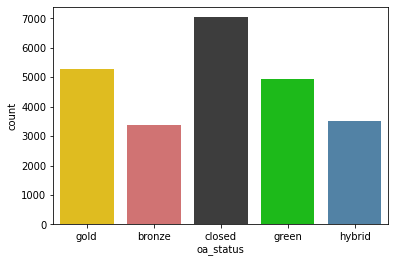

In [18]:
oa_colours = {"closed": "#3d3d3d", "gold":"#ffd000", "green":"#04d400", "hybrid": "#4484b3", "bronze": "#e06363"}
ax = sns.countplot(data = df, x = "oa_status", palette = oa_colours)

count_oa = df.oa_status.value_counts(dropna=True)
percentage_oa = df.oa_status.value_counts(dropna=True, normalize=True).mul(100).round(1).astype(str) + '%'
pd.concat([count_oa,percentage_oa], axis=1, keys=['counts', '%'])

## Number of authors and Open Access status


In [4]:
df['author_list'] = df["author_list"].apply(literal_eval)
df["num_authors"] = df['author_list'].apply(lambda x: len(list(x)))

[Text(0.5, 1.0, 'Number of authors per paper, by Open Access status')]

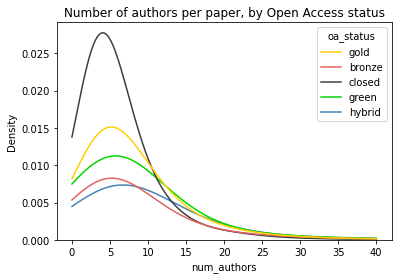

In [19]:
sns.kdeplot(
    data = df, x="num_authors", hue = "oa_status",  
    palette = oa_colours, clip = [0,40]).set(
    title='Number of authors per paper, by Open Access status')


Closed access papers were more likely to have a lower number of authors.

## Institutional affiliation

Analysis of the institutional affiliation of the authors was difficult to do as organisations are not consistently named. Additionally there are many co-authored papers with individuals from organisations outside of the NHS. This is an important area of work for this project - entity recognition and perhaps some kind of authority control list for reference would be helpful.

In [6]:
df["openalex_metadata"] =  df["openalex_metadata"].apply(literal_eval)

In [7]:
df['openalex_institutions'] = df['openalex_metadata'].apply(lambda x: x.get('authorships', "NaN"))

# get openalex institutions
def get_openalex_institutions(openalex_authorships):
  temp_list = []
  for author in openalex_authorships:
    auth_inst_list = author.get("institutions", None)
    if auth_inst_list is not None:
      for inst in auth_inst_list:
        place = inst['display_name']
        if place not in temp_list:
          temp_list.append(place)
  return temp_list

df['openalex_institutions'] = df['openalex_institutions'].apply(lambda x: get_openalex_institutions(x))

Not convinced of the quality of the OpenAlex institutions metadata so I combined it with the info obtained from Pubmed.

In [20]:
#combine affiliations
df['affiliations'] = df['affiliations'].apply(literal_eval)
df['all_institutions'] = df['openalex_institutions'] + df['affiliations']
df['all_institutions'] = df['all_institutions'].apply(lambda x: list(set(x)))

# count number of occurences for each institution using combined Pubmed and OpenAlex data
institution_count_dict = {}
for i in range(df.shape[0]):
  inst_list = df.all_institutions.iloc[i]
  for i in inst_list:
    if i not in institution_count_dict:
      institution_count_dict[i] = 1
    else: 
      institution_count_dict[i] += 1
    
# create df of institution counts only for analysis
inst_df = pd.DataFrame.from_dict(institution_count_dict, orient = "index", columns = ["count"])
inst_df.sort_values(by = 'count', inplace=True, ascending = False)

Below is a list of the most prolific NHS organisations for 2019. However, I know this data is flawed as there is inconsistency in the naming of organisations. Larger trusts also have many hospitals underneath them with different names. This where some important entity recognition work, perhaps using an authority control list or some fuzzy matching, needs to be implemented.

Once this data is cleaned up it would be possible to analyse the relationship between organisation and OpenAccess status, or article topics. 

In [41]:
inst_df.iloc[:10]

# 10 most prolific NHS organisations

,count
King's College London,1931
University College London,1722
University of Manchester,1707
Guy's and St Thomas' NHS Foundation Trust,1648
University of Oxford,1641
University of Cambridge,1626
Imperial College Healthcare NHS Trust,1572
Imperial College London,1306
Leeds Teaching Hospitals NHS Trust,1137
Barts Health NHS Trust,1127


In [38]:
# Imperial College NHS Trust and its hospitals
imperial = inst_df.filter(like='Imperial', axis=0).sum()
charing_cross = inst_df.filter(like='Charing', axis=0).sum()
chelsea = inst_df.filter(like='Chelsea Hospital', axis=0).sum()
hammersmith = inst_df.filter(like='Hammersmith', axis=0).sum()
stmarys = inst_df.filter(like="St Mary's", axis=0).sum()
westerneye = inst_df.filter(like="Western Eye", axis=0).sum()

total_imperial = imperial + charing_cross + chelsea + hammersmith + stmarys + westerneye

print(f"Number of publications for Imperial NHS Trust only: {int(imperial)}")
print(f"Number of publications for Imperial NHS Trust including different hospital names: {int(total_imperial)}")

Number of publications for Imperial NHS Trust only: 3281
Number of publications for Imperial NHS Trust including different hospital names: 4404


## MESH headings

In [8]:
# get concepts from OpenAlex metadata
df['concepts'] = df['openalex_metadata'].apply(lambda x: x.get('concepts', "NaN"))
def get_concepts(list_with_concepts):
  temp_list = []
  for i in list_with_concepts:
    if i['display_name'] not in temp_list:
      temp_list.append(i['display_name'])
  return temp_list
df['concepts'] = df['concepts'].apply(lambda x: get_concepts(x))

In [9]:
# major mesh headings only 

# get major mesh headings
df['major_mesh'] = df['openalex_metadata'].apply(lambda x: x.get('mesh', "NaN"))
def get_major_mesh(list_with_mesh):
  temp_list = []
  for topic_list in list_with_mesh:
    if topic_list['is_major_topic'] == True:
      if topic_list['descriptor_name'] not in temp_list:
        temp_list.append(topic_list['descriptor_name'])
  return temp_list
df['major_mesh'] = df['major_mesh'].apply(lambda x: get_major_mesh(x))

for i in range(df.shape[0]):
  if len(df.major_mesh.iloc[i]) == 0:
    df.major_mesh.iloc[i] = df.concepts.iloc[i]

df['major_mesh'].apply(lambda x: list(set(x)))


# count number of occurences for topic
major_concept_count_dict = {}
for i in range(df.shape[0]):
  concept_list = df.major_mesh.iloc[i]
  for i in concept_list:
    if i not in major_concept_count_dict:
      major_concept_count_dict[i] = 1
    else: 
      major_concept_count_dict[i] += 1

## create df of concept counts only
major_concept_df = pd.DataFrame.from_dict(major_concept_count_dict, orient = "index", columns = ["count"])
major_concept_df.sort_values(by = 'count', inplace=True, ascending = False)
major_concept_df[major_concept_df['count'] >= 50]

# remove not useful subject headings
major_concept_df.drop(['Medicine', 'Internal medicine', 'MEDLINE',  'Disease'] ,inplace = True)

/tmp/ipykernel_491/3663573514.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.major_mesh.iloc[i] = df.concepts.iloc[i]


The table below shows the count of the most frequently occuring MESH Major topics or OpenAlex concepts. Topics that were very general, such as 'Medicine', 'Internal medicine', 'MEDLINE', and 'Disease' were dropped.

Further analysis could map the frequently occuring MESH Major topics with the OpenAccess status for their corresponding papers, to see if specific topics were more likely to be OpenAccess, or not.

In [10]:
major_concept_df.iloc[:10]

,count
Surgery,612
Psychology,521
Intensive care medicine,398
Radiology,357
Magnetic Resonance Imaging,335
Quality of Life,325
Breast Neoplasms,311
Postoperative Complications,289
Neoplasms,284
Prostatic Neoplasms,274


## Natural Language Processing of abstract data

In [47]:
data = pd.DataFrame(df.abstract)

# Added some medical specific terminology to the stopwords list - this could be refined
stop_words = list(set(stopwords.words('english')))
medical_words = ['abstract', 'background', 'methods', 'results', 'conclusion', 'medline', 'patient']
stop_words += medical_words

# Create function to clean text
def clean(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma=WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return lemmatized

# Apply cleaning function
data['clean_text'] = data.abstract.apply(clean)
data['clean_text'] = data['clean_text'].astype('str')

data.head()

,abstract,clean_text
0,Neuromyelitis optica spectrum disorder (NMOSD)...,"['neuromyelitis', 'optica', 'spectrum', 'disor..."
1,Erythromelalgia is a condition characterized b...,"['erythromelalgia', 'condition', 'characterize..."
3,Mycosis fungoides (MF) represents the majority...,"['mycosis', 'fungoides', 'mf', 'represents', '..."
4,BACKGROUND: Malignant middle cerebral artery i...,"['malignant', 'middle', 'cerebral', 'artery', ..."
5,Update of Cochrane Database Syst Rev. 2015 ...,"['update', 'cochrane', 'database', 'syst', 're..."


### LDA analysis of abstract information to try and get primary topics out

This wasn't very successful. Next steps:
- Doing a gridsearch to find best number of components for the LDA 
- Using pretrained word embedding e.g. Biobert or Word2Vec to improve the LDA performance

Further resources:
- https://academic.oup.com/bioinformatics/article/36/4/1234/5566506 
- https://github.com/naver/biobert-pretrained
- https://www.kaggle.com/code/jl18pg052/word-embedding-word2vec-topic-modelling-lda/
- https://www.frontiersin.org/articles/10.3389/frai.2020.00042/full
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0243208
- https://www.frontiersin.org/articles/10.3389/fdgth.2021.686720/full 

In [48]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(data['clean_text'])
lda_model = LatentDirichletAllocation(n_components=100)
lda_vectors = lda_model.fit_transform(data_vectorized)

As you can see from the top 10 topics obtained through LDA analysis, more work could be done to improve the stopwords list (especially with topic 9, for example). This could improve the performance of the model

In [49]:
def print_topics(model, vectorizer):
    for idx, topic in enumerate(model.components_):
        if idx <= 10:
            print("Topic %d:" % (idx))
            print([(vectorizer.get_feature_names_out()[i], topic[i])
                            for i in topic.argsort()[:-10 - 1:-1]])
            
print_topics(lda_model, vectorizer)

Topic 0:
[('patient', 591.1035551078727), ('year', 517.8390761978613), ('copd', 381.71130377191486), ('exacerbation', 334.0111356704396), ('rate', 333.13020718048955), ('cd', 272.67989693172046), ('disease', 230.5299361381919), ('ibd', 213.43818825907115), ('diagnosis', 206.45502701590286), ('incidence', 204.936798635697)]
Topic 1:
[('catheter', 290.48672393465404), ('blood', 278.65206239216775), ('nutrition', 175.20068184517564), ('infusion', 170.22987698314896), ('csf', 159.7184395342562), ('hpn', 127.00999999998606), ('parenteral', 115.20116834154958), ('patient', 112.62887595801172), ('intestinal', 108.35077771898607), ('unit', 83.29056104542725)]
Topic 2:
[('self', 968.0574688878814), ('disorder', 494.1254286122482), ('seizure', 423.552086599376), ('symptom', 396.70518908494813), ('harm', 347.5433728178737), ('autism', 321.6410134261675), ('asd', 320.00999999996804), ('epilepsy', 305.4192980402645), ('social', 290.7210015100881), ('associated', 272.7495307516921)]
Topic 3:
[('pati

# Next steps

<b>Data Sourcing</b>
- Explore usage of Pubmed Entrez API or Selenium to improve data sourcing process

<b>Data augmentation and processing</b>
- Explore usage of Google BigQuery for storing data

<b>Author affiliation</b>
- Create authority list for improved institution detection
- Add OA status to institution DataFrame for analysis

<b>MESH headings</b>
- Map frequently occuring MESH Major topics with the OpenAccess status for their corresponding papers

<b>NLP processing of abstract text for topic detection</b>
- Use WordNet/BioBERT for improved text processing/vectorisation to improve topic detection
- Improve stopwords list for abstracts
- Do gridsearch to identify best number of LDA topics
- Once topic detection model is optimised, allocate topics to papers, try and match these up to MESH headings perhaps? and conduct analysis in relation to OA status
